# Generating trading signals with LightGBM and CatBoost

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import sys, os
from time import time
from collections import defaultdict
from itertools import product

import numpy as np
import pandas as pd
import statsmodels.api as sm

import lightgbm as lgb

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from scipy.stats import spearmanr

from alphalens.tears import (create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.utils import get_clean_factor_and_forward_returns

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')

In [4]:
idx = pd.IndexSlice

In [5]:
YEAR = 252 # days
MONTH = 21 # days

In [6]:
def format_time(t):
    """Return a formatted time string 'HH:MM:SS
    based on a numeric time() value"""
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>2.0f}'

## Get Data

In [7]:
DATA_PATH = Path('..', 'data')

In [8]:
data = (pd.read_hdf(DATA_PATH / 'stock_prices.h5', 'model_data')
            .sort_index())
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1247456 entries, ('A', Timestamp('2007-01-04 00:00:00')) to ('ZMH', Timestamp('2015-06-25 00:00:00'))
Data columns (total 52 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   ret_01       1246956 non-null  float64
 1   ret_03       1245956 non-null  float64
 2   ret_05       1244956 non-null  float64
 3   ret_10       1242456 non-null  float64
 4   ret_21       1236956 non-null  float64
 5   ret_42       1226456 non-null  float64
 6   ret_63       1215956 non-null  float64
 7   ret_126      1184456 non-null  float64
 8   ret_252      1121456 non-null  float64
 9   ret_fwd      1247456 non-null  float64
 10  BB_UP        1237956 non-null  float64
 11  BB_LOW       1237956 non-null  float64
 12  BB_SQUEEZE   1237956 non-null  float64
 13  HT           1215956 non-null  float64
 14  SAR          1246956 non-null  float64
 15  ADX          1233956 non-null  float64
 16  ADXR         12274

## Custom Time Series Cross-Validation

In [9]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits


## Model Selection: Lookback, lookahead and roll-forward periods

In [10]:
tickers = data.index.get_level_values('ticker').unique()

In [11]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month
data['weekday'] = dates.weekday

In [12]:
target = 'ret_fwd'
features = data.columns.drop(target).tolist()

In [13]:
categoricals = ['year', 'month', 'weekday']

In [14]:
train_length = 5 * YEAR
test_length = 3 * MONTH

In [15]:
lookahead = 1

In [16]:
cv_data = data.loc[idx[:, :'2015'], :]

## Baseline: Linear Regression

### One-hot encoding

In [17]:
df = pd.get_dummies(cv_data.loc[:, features + [target]].dropna(), 
                    columns=categoricals, 
                    drop_first=True)
X = df.drop(target, axis=1)
y = df[target]

### Cross-validation setup

In [18]:
n_splits = int(2 * YEAR / test_length)
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_length,
                          lookahead=lookahead,
                          train_period_length=train_length)

### Run cross-validation

In [19]:
lr = LinearRegression()

In [20]:
ic, preds = [], []
for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    preds.append(y_test.to_frame('y_true').assign(y_pred=y_pred))
    ic.append(spearmanr(y_test, y_pred)[0])
preds = pd.concat(preds)

In [21]:
preds.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 250226 entries, ('A', Timestamp('2015-10-02 00:00:00')) to ('ZMH', Timestamp('2014-04-02 00:00:00'))
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   y_true  250226 non-null  float64
 1   y_pred  250226 non-null  float64
dtypes: float64(2)
memory usage: 4.8+ MB


In [22]:
preds.to_hdf(DATA_PATH / 'predictions.h5', 'predictions/lr/train')

### Evaluate Predictions using the Information Coefficient

In [23]:
spearmanr(preds.y_true, preds.y_pred)[0]

0.026703172658321648

In [24]:
daily_ic_lr = preds.groupby(level='date').apply(lambda x: spearmanr(x.y_true, x.y_pred)[0])

In [25]:
daily_ic_lr.describe()

count    504.000000
mean       0.011026
std        0.139408
min       -0.362028
25%       -0.080107
50%        0.010327
75%        0.088693
max        0.442307
dtype: float64

## Regularized Linear Regression

In [26]:
df = pd.get_dummies(cv_data.loc[:, features + [target]].dropna(), 
                    columns=categoricals, 
                    drop_first=True)
X, y = df.drop(target, axis=1), df[target]

In [27]:
n_splits = int(2 * YEAR / test_length)
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_length,
                          lookahead=lookahead,
                          train_period_length=train_length)

In [28]:
alphas = np.logspace(-15, 15, 31)[::2]

In [29]:
alphas

array([1.e-15, 1.e-13, 1.e-11, 1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01,
       1.e+01, 1.e+03, 1.e+05, 1.e+07, 1.e+09, 1.e+11, 1.e+13, 1.e+15])

### Ridge Regression

In [30]:
ic, ridge_preds = [], []
for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
    print(f'\nFold {i}')
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    cv_predictions = []
    for alpha in alphas:
        print(alpha, end=' ', flush=True)
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train, y_train)
        y_pred = ridge.predict(X_test)
        cv_predictions.append(pd.DataFrame({alpha: y_pred},
                                           index=y_test.index))
    ridge_preds.append(pd.concat(cv_predictions, axis=1).assign(y_test=y_test))
ridge_preds = pd.concat(ridge_preds)


Fold 0
1e-15 1e-13 1e-11 1e-09 1e-07 1e-05 0.001 0.1 10.0 1000.0 100000.0 10000000.0 1000000000.0 100000000000.0 10000000000000.0 1000000000000000.0 
Fold 1
1e-15 1e-13 1e-11 1e-09 1e-07 1e-05 0.001 0.1 10.0 1000.0 100000.0 10000000.0 1000000000.0 100000000000.0 10000000000000.0 1000000000000000.0 
Fold 2
1e-15 1e-13 1e-11 1e-09 1e-07 1e-05 0.001 0.1 10.0 1000.0 100000.0 10000000.0 1000000000.0 100000000000.0 10000000000000.0 1000000000000000.0 
Fold 3
1e-15 1e-13 1e-11 1e-09 1e-07 1e-05 0.001 0.1 10.0 1000.0 100000.0 10000000.0 1000000000.0 100000000000.0 10000000000000.0 1000000000000000.0 
Fold 4
1e-15 1e-13 1e-11 1e-09 1e-07 1e-05 0.001 0.1 10.0 1000.0 100000.0 10000000.0 1000000000.0 100000000000.0 10000000000000.0 1000000000000000.0 
Fold 5
1e-15 1e-13 1e-11 1e-09 1e-07 1e-05 0.001 0.1 10.0 1000.0 100000.0 10000000.0 1000000000.0 100000000000.0 10000000000000.0 1000000000000000.0 
Fold 6
1e-15 1e-13 1e-11 1e-09 1e-07 1e-05 0.001 0.1 10.0 1000.0 100000.0 10000000.0 1000000000.0 1

#### Evaluate Predictions

In [31]:
ic_by_day_rg = {}
for alpha in alphas:
    ic_by_day_rg[alpha] = (ridge_preds.groupby(level='date')
                           .apply(lambda x: spearmanr(x[alpha], x.y_test)[0])
                           .mean())

In [32]:
pd.Series(ic_by_day_rg)

1.000000e-15    0.011010
1.000000e-13    0.011010
1.000000e-11    0.011010
1.000000e-09    0.011010
1.000000e-07    0.011010
1.000000e-05    0.011010
1.000000e-03    0.010999
1.000000e-01    0.010147
1.000000e+01    0.007978
1.000000e+03    0.004499
1.000000e+05    0.003247
1.000000e+07    0.002256
1.000000e+09    0.000063
1.000000e+11    0.002798
1.000000e+13    0.002911
1.000000e+15    0.002913
dtype: float64

### Lasso Regression

In [33]:
ic, preds = [], []
for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
    print(f'\nFold {i}')
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    cv_predictions = []
    for alpha in alphas:
        print(alpha, end=' ', flush=True)
        lasso = Lasso(alpha=alpha)
        lasso.fit(X_train, y_train)
        y_pred = lasso.predict(X_test)
        cv_predictions.append(pd.DataFrame({alpha: y_pred},
                                           index=y_test.index))
    preds.append(pd.concat(cv_predictions, axis=1).assign(y_test=y_test))
preds=pd.concat(preds)


Fold 0
1e-15 1e-13 1e-11 1e-09 1e-07 1e-05 0.001 0.1 10.0 1000.0 100000.0 10000000.0 1000000000.0 100000000000.0 10000000000000.0 1000000000000000.0 
Fold 1
1e-15 1e-13 1e-11 1e-09 1e-07 1e-05 0.001 0.1 10.0 1000.0 100000.0 10000000.0 1000000000.0 100000000000.0 10000000000000.0 1000000000000000.0 
Fold 2
1e-15 1e-13 1e-11 1e-09 1e-07 1e-05 0.001 0.1 10.0 1000.0 100000.0 10000000.0 1000000000.0 100000000000.0 10000000000000.0 1000000000000000.0 
Fold 3
1e-15 1e-13 1e-11 1e-09 1e-07 1e-05 0.001 0.1 10.0 1000.0 100000.0 10000000.0 1000000000.0 100000000000.0 10000000000000.0 1000000000000000.0 
Fold 4
1e-15 1e-13 1e-11 1e-09 1e-07 1e-05 0.001 0.1 10.0 1000.0 100000.0 10000000.0 1000000000.0 100000000000.0 10000000000000.0 1000000000000000.0 
Fold 5
1e-15 1e-13 1e-11 1e-09 1e-07 1e-05 0.001 0.1 10.0 1000.0 100000.0 10000000.0 1000000000.0 100000000000.0 10000000000000.0 1000000000000000.0 
Fold 6
1e-15 1e-13 1e-11 1e-09 1e-07 1e-05 0.001 0.1 10.0 1000.0 100000.0 10000000.0 1000000000.0 1

#### Evaluate Predictions

In [36]:
ic_by_day_lasso = {}
for alpha in alphas:
    ic_by_day_lasso[alpha] = preds.groupby(level='date').apply(lambda x: spearmanr(x[alpha], x.y_test)[0]).mean()

In [37]:
pd.Series(ic_by_day_lasso)

1.000000e-15    0.011011
1.000000e-13    0.011011
1.000000e-11    0.011011
1.000000e-09    0.011019
1.000000e-07    0.010513
1.000000e-05    0.005938
1.000000e-03    0.002779
1.000000e-01         NaN
1.000000e+01         NaN
1.000000e+03         NaN
1.000000e+05         NaN
1.000000e+07         NaN
1.000000e+09         NaN
1.000000e+11         NaN
1.000000e+13         NaN
1.000000e+15         NaN
dtype: float64

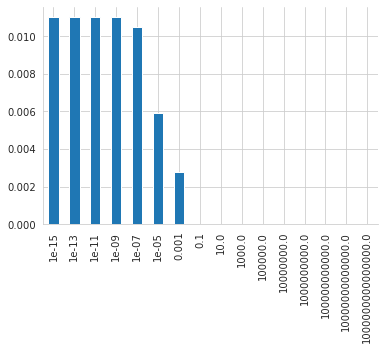

In [38]:
pd.Series(ic_by_day_lasso).plot.bar()
sns.despine();

## LightGBM Model Tuning

In [206]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

### Hyperparameter Options

In [207]:
base_params = dict(boosting='gbdt',
                   objective='regression',
                   metric="None",
                   verbose=-1)

In [208]:
learning_rate_ops = [.01, .1]
max_depths = [5, 7]
num_leaves_opts = [2 ** i for i in max_depths]
feature_fraction_opts = [.5, .95]
min_data_in_leaf_opts = [500, 2000]

In [209]:
param_names = ['learning_rate', 'num_leaves',
               'feature_fraction', 'min_data_in_leaf']

In [210]:
cv_params = list(product(learning_rate_ops,
                         num_leaves_opts,
                         feature_fraction_opts,
                         min_data_in_leaf_opts))
n_params = len(cv_params)
print(f'# Parameters: {n_params}')

# Parameters: 16


### Categorical Variables

In [211]:
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

### Custom Loss Function: Information Coefficient

In [212]:
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], is_higher_better

### Run Cross-Validation

To identify the ideal number of iterations, we 

In [213]:
num_boost_rounds = [10, 25, 50, 75] + list(range(100, 2501, 100))

In [214]:
metric_cols = (param_names + ['t', 'daily_ic_mean', 'daily_ic_mean_n',
                              'daily_ic_median', 'daily_ic_median_n'] +
               [str(n) for n in num_iterations])

In [199]:
lgb_store = 'lgb_tuning.h5'

In [215]:
cvp = np.random.choice(list(range(n_params)),
                       size=int(n_params / 1),
                       replace=False)
cv_params_ = [cv_params[i] for i in cvp]

In [216]:
n_splits = int(2 * YEAR / test_length)
print(f'Train: {train_length:3.0f} | '
      f'Test: {test_length:2.0f} | '
      f'Params: {len(cv_params_):3.0f}')

Train: 1260 | Test: 63 | Params:  16


In [217]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          lookahead=lookahead,
                          test_period_length=test_length,
                          train_period_length=train_length)

In [ ]:
T = 0
for p, param_vals in enumerate(cv_params_):
#     key = f'{train_length}/{test_length}/' + '/'.join([str(p) for p in param_vals])
    key = '/'.join([str(p) for p in param_vals])
    model_key = '_'.join([str(p) for p in param_vals])
    params = dict(zip(param_names, param_vals))
    params.update(base_params)
    start = time()
    
    daily_ic_mean = np.full(shape=(n_splits, 
                              len(num_boost_rounds)),
                      fill_value=np.nan)
    # train on data through 2015 to select the best model
    for n_split, (train_idx, test_idx) in enumerate(cv.split(X=cv_data)):
        print(f'{n_split} |', end=' ', flush=True)
        train_set = cv_data.iloc[train_idx, :]
        lgb_train = lgb.Dataset(data=train_set.loc[:, features],
                       label=train_set[target],
                       categorical_feature=categoricals,
                       free_raw_data=False)
        
        test_set = cv_data.iloc[test_idx, :]
        X_test = test_set.loc[:, features]
        y_test = test_set.loc[:, target].to_frame('y_true')
        
        model = None
        current_iteration = 0
        best_score, best_iteration = -np.inf, 0
        for i, num_boost_round in enumerate(num_boost_rounds):
            model = lgb.train(params=params,
                              init_model=model,
                              train_set=lgb_train,
                              num_boost_round=num_boost_round - current_iteration,
                              verbose_eval=False)
            current_iteration = model.current_iteration()
            y_test = y_test.assign(y_pred=model.predict(X_test))
            daily_ic = y_test.groupby(level='date').apply(lambda x: spearmanr(x.y_true, x.y_pred)[0]).mean()
            daily_ic_mean[n_split, i] = daily_ic
            
            # manual early stopping to save some training time
            if daily_ic > best_score:
                best_score = daily_ic
                best_iteration = num_boost_round
#             else:
#                 if num_boost_round - best_iteration > 2500:
#                     print(f'{num_boost_round:6,.0f} | {best_score:6.2%}', flush=True)
#                     break
            if num_boost_round == num_boost_rounds[-1]:
                print(f'{num_boost_round:6,.0f} | {best_score:6.2%}', flush=True)
        model.save_model('models/' + model_key + f'_{n_split}.txt')

    t = time() - start
    T += t
    ic = pd.DataFrame(daily_ic_mean.T, 
                          columns=list(range(1, n_splits+1)),
                          index=num_boost_rounds)
    
    ic_mean = ic.dropna().mean(1).max()
    ic_mean_n = ic.dropna().mean(1).idxmax()

    msg = f'\n{p:3.0f} | {format_time(T)} | {format_time(t)} | {params["learning_rate"]:5.2f} | '
    msg += f'{params["num_leaves"]:3.0f} | {params["feature_fraction"]:3.0%} | {params["min_data_in_leaf"]:4.0f} | '
    msg += f' {ic_mean:6.2%} | {ic_mean_n:5.0f}'
    print(msg)
    ic.to_hdf(lgb_store, 'ic/' + key)

0 |  2,500 |  3.71%
1 |  2,500 |  6.36%
2 |  2,500 |  2.99%
3 |  2,500 |  3.09%
4 |  2,500 |  4.03%
5 |  2,500 |  1.47%
6 |  2,500 |  2.70%
7 |  2,500 |  2.26%

  0 | 02:31:25 | 02:31:25 |  0.10 | 128 | 95% | 2000 |   2.90% |   200
0 |  2,500 |  4.29%
1 |  2,500 |  6.44%
2 |  2,500 |  2.34%
3 |  2,500 |  1.98%
4 |  2,500 |  3.59%
5 |  2,500 |  0.75%
6 |  2,500 |  2.93%
7 |  2,500 |  3.21%

  1 | 03:18:23 | 00:46:57 |  0.10 |  32 | 95% | 2000 |   2.65% |   400
0 |  2,500 |  4.00%
1 |  2,500 |  5.67%
2 |  2,500 |  2.07%
3 |  2,500 |  3.51%
4 |  2,500 |  4.05%
5 |  2,500 |  1.11%
6 |  2,500 |  2.01%
7 |  2,500 |  2.70%

  2 | 05:37:06 | 02:18:44 |  0.10 | 128 | 50% | 2000 |   2.70% |   100
0 |  2,500 |  3.77%
1 |  2,500 |  6.74%
2 |  2,500 |  2.79%
3 |  2,500 |  1.96%
4 |  2,500 |  3.69%
5 |  2,500 |  0.42%
6 |  2,500 |  2.11%
7 |  2,500 |  2.30%

  3 | 07:02:10 | 01:25:03 |  0.10 | 128 | 95% |  500 |   2.62% |   300
0 |  2,500 |  4.77%
1 |  2,500 |  5.59%
2 |  2,500 |  2.55%
3 |  2,500 |

In [ ]:
to_drop = ['boosting', 'objective', 'verbose']
id_cols = ['learning_rate', 'num_leaves',
           'feature_fraction', 'min_data_in_leaf',
           'train_test', 'date']

daily_ic = []
with pd.HDFStore(lgb_store) as store:
    for key in store.keys():
        if key[1:].startswith('daily_ic'):
            train_length, test_length = key.replace(
                '/daily_ic/', '').split('/')[:2]
            df = store[key].drop(to_drop, axis=1).assign(train_test=train_length + '_' + test_length)
            daily_ic.append(pd.melt(df.reset_index(),
                                    id_vars=id_cols,
                                    var_name='nrounds',
                                    value_name='ic'))
daily_ic = pd.concat(daily_ic).dropna()
daily_ic['date'] = pd.factorize(daily_ic['date'], sort=True)[0]
daily_ic.nrounds = daily_ic.nrounds.astype(int)
daily_ic = daily_ic.sort_values(id_cols[:-1])

In [ ]:
daily_ic.info()

In [ ]:
daily_ic_avg = (daily_ic
                .groupby(id_cols[:-1] + ['nrounds'])
                .ic.mean()
                .to_frame('ic')
                .reset_index()
                .sort_values('ic', ascending=False))

In [ ]:
daily_ic_avg.info()

In [ ]:
train_test = daily_ic_avg.train_test.str.split('_', expand=True).astype(int)
train_test.columns= ['train_length', 'test_length']
daily_ic_avg = daily_ic_avg.drop('train_test', axis=1).join(train_test)

In [ ]:
with pd.HDFStore(lgb_store) as store:
    best_preds = store['predictions/1260/63/0.01/32/0.3/250']

In [ ]:
spearmanr(best_preds.y_test, best_preds['1500'])[0]

In [ ]:
best_preds['2500'].to_hdf('predictions.h5', 'predictions')

### AlphaLens Analysis

#### Prepare Factor Data

In [ ]:
t = 1
idx = pd.IndexSlice
factor = (pd.read_hdf('predictions.h5', 'predictions/lr').y_pred
          .sort_index()
          .dropna()
          .tz_localize('UTC', level='date')
          .swaplevel())

In [ ]:
dates = factor.index.get_level_values('date')
dates.min(), dates.max()

In [ ]:
factor.head()

#### Select next available trade prices

Using next available prices.

In [ ]:
def get_trade_prices(tickers):
    return (pd.read_hdf(DATA_STORE, 'us_stocks')
              .loc[idx[tickers, '2006':'2017'], 'open']
              .unstack('ticker')
              .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [ ]:
tickers = factor.index.get_level_values('ticker').unique()

In [ ]:
trade_prices = get_trade_prices(tickers)
trade_prices.info()

#### Get AlphaLens Inputs

In [ ]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))
factor_data.sort_index().info()

#### Summary Tearsheet

In [ ]:
create_summary_tear_sheet(factor_data)

## Generate LightGBM predictions

### Model Configuration

In [ ]:
base_params = dict(boosting='gbdt',
                   objective='regression',
                   verbose=-1)

categoricals = ['year', 'month', 'weekday']

### Get Data

In [ ]:
lgb_data = lgb.Dataset(data=data[features],
                       label=data[target],
                       categorical_feature=categoricals,
                       free_raw_data=False)

### Generate predictions

In [ ]:
best_params = (daily_ic_avg.nlargest(5,
                                     columns=['ic'])
               .drop('ic', axis=1)
               .to_dict('records'))

In [ ]:
for position, params in enumerate(best_params):
    train_length = params.pop('train_length')
    test_length = params.pop('test_length')
    num_boost_round = params.pop('nrounds')
    params.update(base_params)

    n_splits = int(1 * YEAR / test_length)
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              test_period_length=test_length,
                              lookahead=lookahead,
                              train_period_length=train_length)

    predictions = []
    start = time()
    for fold, (train_idx, test_idx) in enumerate(cv.split(X=data), 1):
        print(fold, end=' ', flush=True)
        lgb_train = lgb_data.subset(train_idx.tolist()).construct()

        model = lgb.train(params=params,
                          train_set=lgb_train,
                          num_boost_round=num_boost_round,
                          verbose_eval=False)

        test_set = data.iloc[test_idx, :]
        y_test = test_set.loc[:, target].to_frame('y_test')
        y_pred = model.predict(test_set.loc[:, model.feature_name()])
        predictions.append(y_test.assign(prediction=y_pred))

    if position == 0:
        test_predictions = (pd.concat(predictions)
                            .rename(columns={'prediction': position}))
    else:
        test_predictions[position] = pd.concat(predictions).prediction

In [ ]:
test_predictions.to_hdf('predictions.h5', f'lgb/test')

In [ ]:
by_day = test_predictions.groupby(level='date')
for position in range(5):
    if position == 0:
        ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0]).to_frame()
    else:
        ic_by_day[position] = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0])
print(ic_by_day.describe())
ic_by_day.to_csv(f'ic_by_day_test.csv')

### AlphaLens Analysis

#### Prepare Factor Data

In [ ]:
t = 1
idx = pd.IndexSlice
factor = (pd.read_hdf('predictions.h5', 'lgb/test')
          .drop('y_test', axis=1)
          .iloc[:, :5]
          .mean(1)
          .sort_index()
          .dropna()
          .tz_localize('UTC', level='date')
          .swaplevel())

In [ ]:
dates = factor.index.get_level_values('date')
dates.min(), dates.max()

In [ ]:
factor.head()

#### Select next available trade prices

In [ ]:
tickers = factor.index.get_level_values('ticker').unique()

In [ ]:
trade_prices = get_trade_prices(tickers)
trade_prices.info()

#### Get AlphaLens Inputs

In [ ]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))
factor_data.sort_index().info()

#### Summary Tearsheet

In [ ]:
create_summary_tear_sheet(factor_data)

#### Full Tearsheet

In [ ]:
create_full_tear_sheet(factor_data,
                       long_short=True, 
                       group_neutral=False, 
                       by_group=True)